<a href="https://colab.research.google.com/github/JinseongP/Basic-AI/blob/main/day5/5_2_stock_prediction_with_deep_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ref: https://github.com/SLCFLAB/Data-Science-Python

# Stock Price Prediction with RNN

For this part of today's session, you will practice how to predict future stock prices using vanilla RNN. This is a simple example and it's difficult to say that quant traders use this kind of model to generate signal. But it's important to understand the basic system so please carefully read along the code.

I refer to this blog post: https://data-science-hi.tistory.com/190

In [1]:
# !pip install --upgrade pandas
!pip install pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler

## Get financial data with pandas datareader

**pandas-datareader** is widely used to get daily transaction data. I will show you how to use it. And with this library, we will download 'Samsung Electronics' stock prices.

In [3]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022,8,2)

In [4]:
kospi = pdr.DataReader('KOSPI', 'naver', start, end)

In [5]:
kospi

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-02,1831.69,1837.81,1814.55,1826.37,323358
2012-01-03,1846.56,1875.41,1846.56,1875.41,443474
2012-01-04,1883.48,1884.69,1866.22,1866.22,494500
2012-01-05,1869.42,1875.97,1860.57,1863.74,533768
2012-01-06,1867.12,1867.12,1824.29,1843.14,472680
...,...,...,...,...,...
2022-07-27,2412.52,2415.53,2396.19,2415.53,333587
2022-07-28,2437.57,2443.43,2429.07,2435.27,491073
2022-07-29,2453.53,2463.05,2442.01,2451.5,499369


In [6]:
kospi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2607 entries, 2012-01-02 to 2022-08-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    2607 non-null   object
 1   High    2607 non-null   object
 2   Low     2607 non-null   object
 3   Close   2607 non-null   object
 4   Volume  2607 non-null   object
dtypes: object(5)
memory usage: 122.2+ KB


In [7]:
kospi = kospi.astype(np.float64)

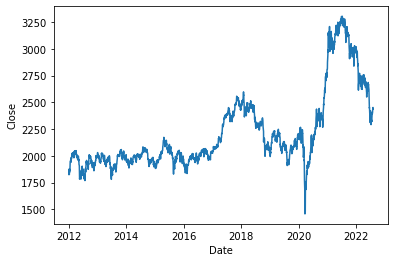

In [8]:
sns.lineplot(data = kospi.iloc[:,-2])
plt.show()

In [13]:
samsung = pdr.DataReader('005930', 'naver', start=start, end=end)

In [14]:
samsung

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-02,21400,21600,21300,21600,263300
2012-01-03,21860,22100,21840,22100,339046
2012-01-04,22100,22200,21500,21600,342389
2012-01-05,21460,21580,21100,21100,346691
2012-01-06,21120,21319,20600,20800,376753
...,...,...,...,...,...
2022-07-27,61300,61900,61200,61800,7320997
2022-07-28,62300,62600,61600,61900,10745302
2022-07-29,62400,62600,61300,61400,15093120


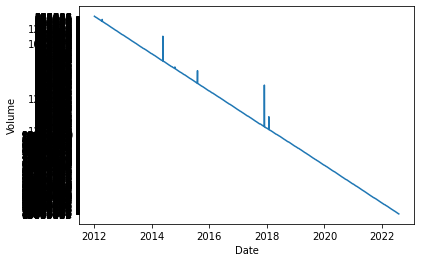

In [15]:
sns.lineplot(data = samsung.iloc[:,-1])
plt.show()

In [16]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2607 entries, 2012-01-02 to 2022-08-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    2607 non-null   object
 1   High    2607 non-null   object
 2   Low     2607 non-null   object
 3   Close   2607 non-null   object
 4   Volume  2607 non-null   object
dtypes: object(5)
memory usage: 122.2+ KB


## Price Prediction

In [17]:
scaler = MinMaxScaler()

In [18]:
samsung['High, Low, Open, Close, Volume'.split(', ')] = scaler.fit_transform(samsung['High, Low, Open, Close, Volume'.split(', ')])

In [19]:
samsung.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-02,0.236988,0.223140,0.237989,0.018110,0.002916
2012-01-03,0.242082,0.228306,0.244022,0.025184,0.003754
2012-01-04,0.244740,0.229339,0.240223,0.018110,0.003791
2012-01-05,0.237652,0.222934,0.235754,0.011036,0.003839
2012-01-06,0.233887,0.220238,0.230168,0.006791,0.004172


In [20]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2607 entries, 2012-01-02 to 2022-08-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2607 non-null   float64
 1   High    2607 non-null   float64
 2   Low     2607 non-null   float64
 3   Close   2607 non-null   float64
 4   Volume  2607 non-null   float64
dtypes: float64(5)
memory usage: 122.2 KB


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
print(f"{device} is avaiable")
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))

cuda:0 is avaiable
Tesla T4


In [22]:
df = samsung.copy()

In [23]:
X = df['Open, High, Low, Volume'.split(', ')].values
y = df['Close'].values

In [24]:
def seq_data(x, y, sequence_length):
  
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[i: i+sequence_length])
    y_seq.append(y[i+sequence_length])

  x_seq = np.array(x_seq)
  y_seq = np.array(y_seq)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])

In [25]:
split_size = 0.8
split_index = int(len(X) * split_size)
print(split_index)

2085


In [26]:
sequence_length = 5

In [27]:
x_seq, y_seq = seq_data(X, y, sequence_length)

x_train_seq = x_seq[:split_index]
y_train_seq = y_seq[:split_index]
x_test_seq = x_seq[split_index:]
y_test_seq = y_seq[split_index:]
print(x_train_seq.shape, y_train_seq.shape)
print(x_test_seq.shape, y_test_seq.shape)

torch.Size([2085, 5, 4]) torch.Size([2085, 1])
torch.Size([517, 5, 4]) torch.Size([517, 1])


In [28]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [29]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [30]:
class VanillaRNN(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out)
    return out
    
model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)


In [31]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

In [32]:
loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data # 배치 데이터.
    out = model(seq)   # 모델에 넣고,
    loss = criterion(out, target) # output 가지고 loss 구하고,

    optimizer.zero_grad() # 
    loss.backward() # loss가 최소가 되게하는 
    optimizer.step() # 가중치 업데이트 해주고,
    running_loss += loss.item() # 한 배치의 loss 더해주고,

  loss_graph.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  if epoch % 20 == 0:
    print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))

[epoch: 0] loss: 0.0518
[epoch: 20] loss: 0.0010
[epoch: 40] loss: 0.0006
[epoch: 60] loss: 0.0005
[epoch: 80] loss: 0.0004
[epoch: 100] loss: 0.0003
[epoch: 120] loss: 0.0003
[epoch: 140] loss: 0.0002
[epoch: 160] loss: 0.0003
[epoch: 180] loss: 0.0005


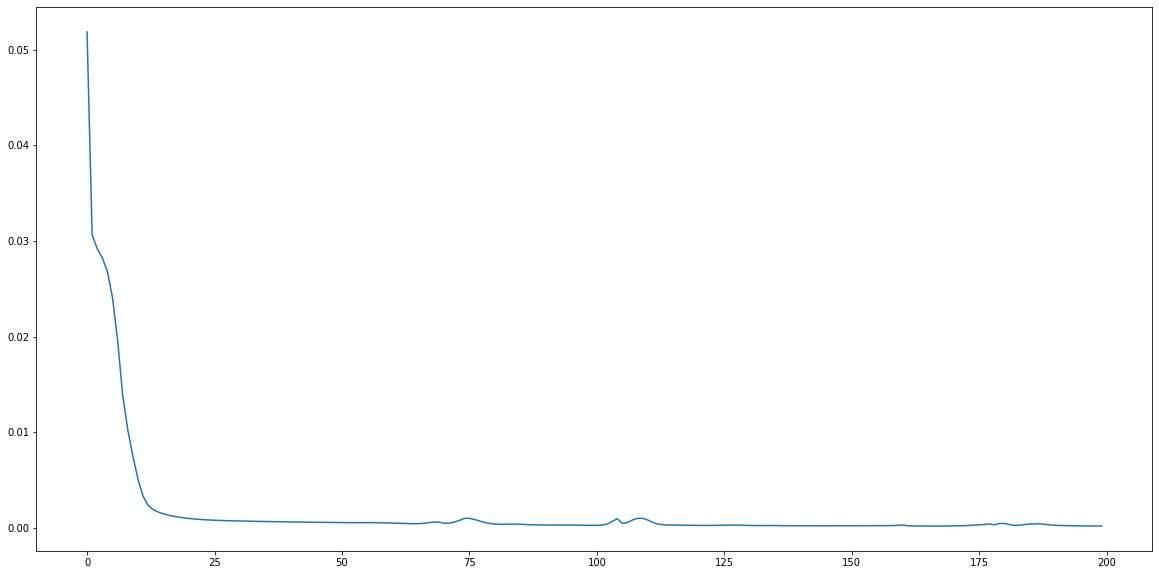

In [33]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

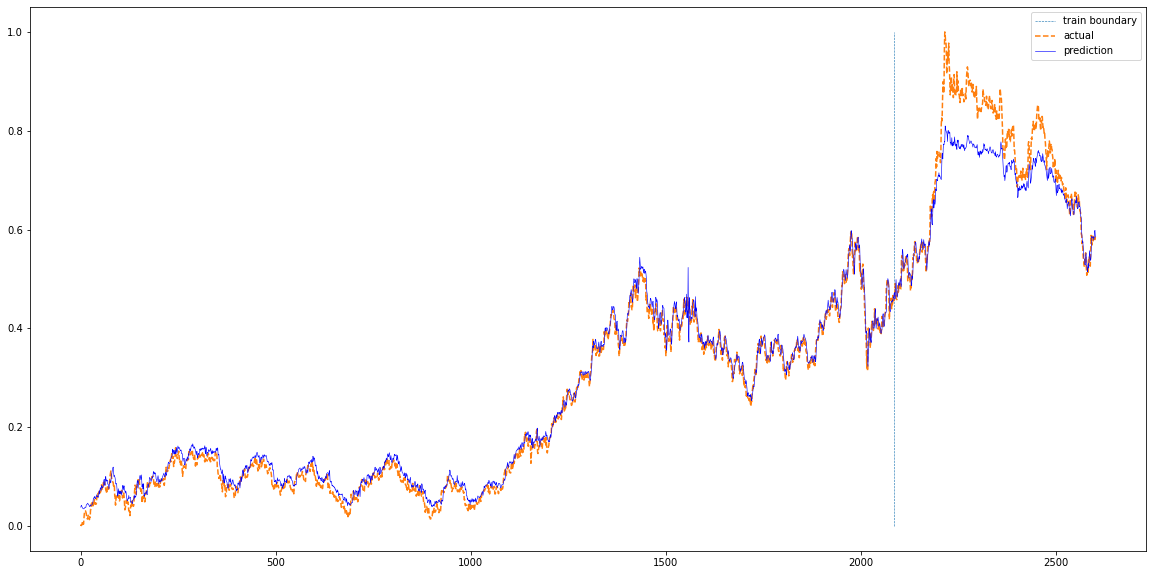

In [34]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
      
  total = train_pred + test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['train boundary', 'actual', 'prediction'])
  plt.show()

plotting(train_loader, test_loader, df['Close'].iloc[sequence_length:].values)